#Optimisation with Genetic Algorithms

Let us start by importing the libraries we'll be needing in this lab :

In [ ]:
import numpy as np
import random
import struct
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import Image

## Problem 1: Extremas with the genetic algorithm

In this part, we'll be trying to find the extremums of the given functions using the genetic algorithm. First, let us implement these 2 functions into code, while making sure they only recieve values in the specified interval of **[-10, 10]** :

In [ ]:
def fct_a(x,y):
    if not(-10<=x<=10 and -10<=y<=10):
        raise ValueError(f'Value ({x},{y}) out of range [-10, 10]^2')
        return None
    else:
        try:
            return np.exp(-x**2-(y+1)**2)*3*(1-x)**2-10*np.exp(-x**2-y**2)*(x/5-x**3-y**5)-np.exp(-(x+1)**2-y**2)/3
        except Exception as e:
            print(f'Error in fct_a: {e}')
            return None

In [ ]:
def fct_b(x,y):
    if not(-10<=x<=10 and -10<=y<=10):
        raise ValueError(f'Value ({x},{y}) out of range [-10, 10]^2')
        return None
    else:
        try:
            return -0.0001*(abs(np.sin(x)*np.sin(y)*np.exp(abs(100-(x**2+y**2)**0.5/np.pi)))+1)**0.1
        except Exception as e:
            print(f'Error in fct_b: {e}')
            return None

In [ ]:
def minus_fct_b(x,y):
    return -fct_b(x,y)

In [ ]:
print(fct_a(1,1))
print(fct_a(3,6))
print(fct_a(-0.08,1.59))
print(fct_b(1,3))
print(fct_b(9,9))
#print(fct_b(3,-11))

2.4337891159260003
2.2334514893633567e-15
8.063839193037925
-1.609504497706071
-1.230263542545158


We'll try to find the maximum of **fct_a** and the minimum of **fct_b** (or the maximum of **-fct_b**, which we already defined) by implementing a **Genetic Algorithm (GA)**.

In [ ]:
#Image(filename='/content/drive/MyDrive/HSE/Semester 2/MMDM/imgs/Flow-chart-of-genetic-algorithm.png')

A **Genetic Algorithm** is a search heuristic that is inspired by the process of **natural selection**. It is used to find **approximate solutions** to **optimization and search problems**. The algorithm starts with a population of **candidate solutions** (randomly chosen), which are represented as chromosomes. Each chromosome is evaluated using a **fitness function**, which measures how well the solution solves the problem. The fittest chromosomes are then **selected for reproduction**, and their genetic material is combined to create new offspring. The offspring are then **mutated and recombined** to create a new population of candidate solutions. This process is repeated until a satisfactory solution is found.<br>
Genetic algorithms can be used to find extremums of functions by considering the studied function as the fitness function.

Now, we will try implementing this algorithm to find **max(fct_a(x,y)**) and **min(fct_b(x,y))** for x and y in [-10, 10].<br>
Firstly, we initialise the population :

In [ ]:
def InitialPopulation(n_vars, min_vals, max_vals, pop_size):
    init_pop = []
    for i in range(pop_size):
        init_pop.append(tuple(random.uniform(min_val,max_val) for min_val, max_val in zip(min_vals, max_vals)))
    return init_pop

Here, we note that we're making a general algorithm for **functions with n variables**, and the **population size** is a parameter of the Genetic Algorithm, which we will take equal to 100 for the time being.<br>
Now, we will implement the **Selection** step. Given a **population** and a list of **fitnesses** (values for the given function, every individual in the population is composed of variables that could be passed to the function we want to find the extremums of. Of course, in our application, it would be a pair of variables (x,y)), we will try to select a **list of individuals** out of the population for the crossover, called **parents**. Let us note that there are a number of ways to choose parents (random, tournament, proportional...), but here, firstly, we will decide based on the **fitness function values** using the **proportional selection** approach. It means we assign a probability to each individual proportional to its fitness value, then we randomly choose a number of possible parents taking into account those probabilities.

In [ ]:
def Selection(population, fits):
    #Rescaling
    _fits = (fits-min(fits))+1
    sum_fits = sum(_fits)
    probs = [_fit/sum_fits for _fit in _fits]
    indices =  np.random.choice(np.arange(len(population)),size=len(population),p=probs)
    return [population[i] for i in indices]

Also, another selection algorithm was implemented: tournament selection. Both worked, but tournament selection gives slightly more accurate results.

In [ ]:
def Tournament_Selection_GA(population, fct_, k=5):
    selected = []
    for _ in range(len(population)):
        #Choose k random indvs
        tournament_indices = random.sample(range(len(population)), k)
        best_idx = tournament_indices[0]
        for idx in tournament_indices[1:]:
            indv = np.array(population[idx])
            best_indv = np.array(population[best_idx])
            if fct_(*indv) > fct_(*best_indv):
                best_idx = idx
        selected.append(population[best_idx])
    return selected

Now to the crossover step :

In [ ]:
def Crossover(parents, crossover_rate):
    children = []
    for idx in range(len(parents)):
        parent_a, parent_b = random.sample(parents,2)
        if random.random() < crossover_rate:
            cross_point = random.randint(0, len(parent_b)-1)
            children.append(parent_a[:cross_point]+parent_b[cross_point:])
        else:
            children.append(parent_b)
    return children

Following it, the mutation step (binary mutation isn't quite working as it gives individuals out of range, so we were content with regular mutation of vector elements of an individual as shown below):

In [ ]:
def EncodeToBinary(indv, n_bits):
    return [format(struct.unpack('I', struct.pack('f', x))[0], '0{}b'.format(n_bits)) for x in indv]

In [ ]:
def DecodeFromBinary(indv_bin):
    return [struct.unpack('f', struct.pack('I', int(x_bin, 2)))[0] for x_bin in indv_bin]

In [ ]:
def Mutation(pop, mutation_rate, min_val=-10, max_val=10, n_bits=8):
    mutated_pop = []
    for indv in pop:
        '''
        bin_indv = EncodeToBinary(indv, n_bits)
        bin_indv = ''.join(bin_indv)
        bin_x = ''
        mut_bin_indv = []
        for i, bit in enumerate(bin_indv):
            if random.random() < mutation_rate:
                #Flip the bit
                bin_x += str(1-int(bit))
            else:
                bin_x += bit
            if(len(bin_x) == n_bits):
                mut_bin_indv.append(bin_x)
                bin_x = ''
        mutated_pop.append(DecodeFromBinary(mut_bin_indv))
        '''
        if random.random() < mutation_rate:
            mutation_point = random.randint(0, len(indv)-1)
            mutation_value = random.uniform(min_val, max_val)
            mutated_pop.append(indv[:mutation_point]+(mutation_value,)+indv[mutation_point+1:])
        else:
            mutated_pop.append(indv)
    return mutated_pop

Finally, we can implement the genetic algorithm by assembling all the sections together. The hyperparemeters are defined as follows:

In [ ]:
n_vars = 2
min_vals = [-10]*n_vars
max_vals = [10]*n_vars
pop_size = 100
crossover_rate = 0.9
mutation_rate = 0.1
generations = 500

We implement the algorithm code, and we test it :

In [ ]:
def GeneticAlgorithm(fct_):
    init_pop = InitialPopulation(n_vars, min_vals, max_vals, pop_size)
    print('Initial values: ',init_pop)
    current_pop = init_pop[:]
    for _ in range(generations):
        fits = [fct_(indv[0],indv[1]) for indv in current_pop]
        #print(fits)
        #Proportional selection:
        #parents = Selection(current_pop, fits)
        #Tournament selection:
        parents = Tournament_Selection_GA(current_pop, fct_,k=3)
        children = Crossover(parents, crossover_rate)
        current_pop = Mutation(children, mutation_rate)
    print('Genetic Algorithm results: ', current_pop)
    return max(current_pop, key=lambda x: fct_(*x))

Now, we can test the obtained results:

In [ ]:
from scipy.optimize import minimize
#bounds = Bounds(-10,10)
bounds = [(-10,10), (-10,10)]
init_pt = [random.uniform(-10, 10) for _ in range(n_vars)]

print('max fct_a: ')
#Genetic algorithm
max_a = GeneticAlgorithm(fct_a)
print(f'max fct_a is {fct_a(*max_a)} obtained for (x,y)={max_a}')
#Verification
max_a_verif = minimize(lambda x: -fct_a(*x), init_pt, method='Powell', bounds=bounds, tol=1e-10)
print(f'verifiying with scipy: max fct_a is {-max_a_verif.fun} obtained for (x,y)={max_a_verif.x}\n')

print('min fct_b: ')
#Genetic algorithm
min_b = GeneticAlgorithm(minus_fct_b)
print(f'min fct_b is {fct_b(*min_b)} obtained for (x,y)={min_b}')
#Verification
min_b_verif = minimize(lambda x: fct_b(*x), init_pt, method='Powell', bounds=bounds, tol=1e-8)
print(f'verifiying with scipy: min fct_b is {min_b_verif.fun} obtained for (x,y)={min_b_verif.x}')

max fct_a: 
Initial values:  [(6.09547093291129, 1.2310068626238717), (5.022213032283599, 3.619354930636508), (-9.73799121195417, 8.220631788899116), (8.414005413024384, -1.0654033673201546), (-4.428655404409576, 7.2864000491813705), (-7.632897694275198, -7.613402792698441), (6.8456411874152, 2.461855175010104), (5.074496167067732, -0.5414454661669676), (-4.329212323471903, -5.634802401850713), (3.296336199325891, -6.126782275235141), (9.550531742390639, 7.973758141104273), (-0.7370013645397755, -4.316467095753342), (0.43732252175029984, -5.168615798811322), (1.9736445526984028, 1.354790176958394), (-4.896330033815019, -8.634565835063285), (-6.090747004341588, -4.756834328902766), (8.533995928361279, 9.650175192115892), (1.7409465392568215, -7.942324560308494), (-9.7995751590765, -7.854622800145279), (7.699815903397049, -2.6557788615252553), (-5.397005662016552, -3.9204702571519734), (-8.689316274339049, -6.457099023721353), (-0.6778816674293413, 8.797059589630951), (-3.093440849742310

**Note:** the results of the function minimize from the scipy lib depends on the initial condition or searching point (hence the difference in some cases from the GA results)

So we get:
* $max_{(x,y)}~f_a(x,y) \approx 8.106$
* $min_{(x,y)}~f_b(x,y) \approx -2.06$

Let us visualise the solutions:

In [ ]:
def Visualise_sol(f, Points, lb=-10, hb=10):
    x = np.linspace(lb,hb,100)
    y = np.linspace(lb,hb,100)
    X, Y = np.meshgrid(x,y)
    Z = f(X,Y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X,Y,Z, alpha = 0.3)
    for Point in Points:
        ax.scatter(Point[0], Point[1], f(*Point), color='red', s=50)
    plt.show()

Maximum of function A:

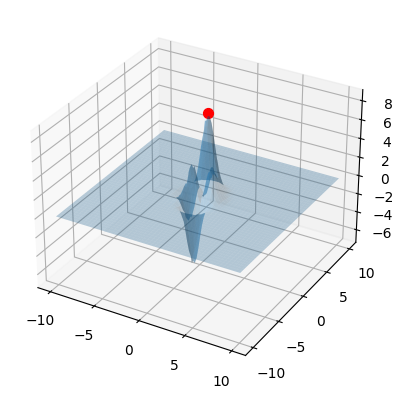

In [ ]:
f_a = lambda x,y: np.exp(-x**2-(y+1)**2)*3*(1-x)**2-10*np.exp(-x**2-y**2)*(x/5-x**3-y**5)-np.exp(-(x+1)**2-y**2)/3
Visualise_sol(f_a, [max_a])

Minimum of function B:

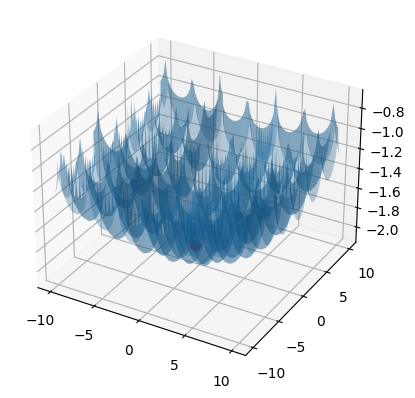

In [ ]:
f_b = lambda x,y: -0.0001*(abs(np.sin(x)*np.sin(y)*np.exp(abs(100-(x**2+y**2)**0.5/np.pi)))+1)**0.1
Visualise_sol(f_b, [min_b])

## Problem 2: finding extremums using the NSGA-II algorithm

In this part, we'll be trying to find the **pareto front** (solutions that are not dominated by any other solution) corresponding to the problem of minimizing the 2 given functions using the **NSGA-II** algorithm. First, let us implement these 2 functions into code, while making sure they only recieve values in the specified interval of **[-4, 4]** :

In [ ]:
def fct_1(x):
    n = len(x)
    in_domain = True
    for x_ in x:
        in_domain *= -4<=x_<=4
    if not in_domain:
        raise ValueError(f'Value {x} out of range [-4, 4]^{len(x)}')
        return None
    else:
        try:
            return 1-np.exp(-sum([(x_-1/n**0.5)**2 for x_ in x]))
        except Exception as e:
            print(f'Error in fct_a: {e}')
            return None

In [ ]:
def fct_2(x):
    n = len(x)
    in_domain = True
    for x_ in x:
        in_domain *= -4<=x_<=4
    if not in_domain:
        raise ValueError(f'Value {x} out of range [-4, 4]^{len(x)}')
        return None
    else:
        try:
            return 1-np.exp(-sum([(x_+1/n**0.5)**2 for x_ in x]))
        except Exception as e:
            print(f'Error in fct_b: {e}')
            return None

In [ ]:
def evaluate(x):
    return (fct_1(x), fct_2(x))

Let's quickly test these functions:

In [ ]:
x = [1,2,3,4]
print(fct_1(x))
print(fct_2(x))

0.999999999241744
1.0


The **NSGA-II** (Non-dominated Sorting Genetic Algorithm II) is a **multi-objective optimization algorithm** that efficiently finds a set of Pareto-optimal solutions. It combines the principles of genetic algorithms with non-dominated sorting and elitism to evolve a diverse set of solutions that are not dominated by any other solution in the population.

Here's a summary of its steps:<br>
1. **Initialization**: Start with a randomly generated population of individuals.<br>
2. **Evaluation**: Evaluate the fitness of each individual based on multiple objective functions.<br>
3. **Non-dominated Sorting**: Rank individuals based on their dominance relationship. Individuals in the first rank are non-dominated and form the first Pareto front, followed by subsequent fronts.<br>
4. **Crowding Distance Assignment**: Calculate the crowding distance for individuals in each front to maintain diversity. Individuals with greater crowding distance are preferred.<br>
5. **Selection**: Select individuals for the next generation using a combination of non-dominated sorting and crowding distance. Elitism ensures that the best solutions are preserved.<br>
6. **Crossover and Mutation**: Apply genetic operators like crossover and mutation to create offspring individuals.<br>
7. **Replacement**: Create the next generation by combining parents and offspring, maintaining the population size.<br>
8. **Repeat**: Repeat the process until a termination condition is met, such as reaching a maximum number of generations or converging to a satisfactory solution set.


This algorithm differs from regular genetic algorithms especially in its handling of multi-objective optimization tasks. Unlike traditional GAs, it is specifically designed to tackle problems with multiple conflicting objectives, employing non-dominated sorting to rank solutions along the pareto front and ensuring population diversity through mechanisms like crowding distance. Additionally, it incorporates elitism by preserving the best solutions across generations, thus contributing to its efficiency in exploring diverse solution spaces.

In conclusion, NSGA-II effectively balances exploration and exploitation, providing a diverse set of solutions allowing us to choose the most suitable one.

Let us try implementing this algorithm. We start by a selection algorithm. This time, we will use tournament selection instead.

In [ ]:
def Is_Dominant(indv_a,indv_b):
    #True if a dominates b, false otherwise
    return fct_1(indv_a) < fct_1(indv_b) and fct_2(indv_a) < fct_2(indv_b)

In [ ]:
def Tournament_Selection(population, k=5):
    selected = []
    for _ in range(len(population)):
        #Choose k random indvs
        tournament_indices = random.sample(range(len(population)), k)
        best_idx = tournament_indices[0]
        for idx in tournament_indices[1:]:
            if Is_Dominant(population[idx], population[best_idx]):
                best_idx = idx
        selected.append(population[best_idx])
    return selected

Now we implement the non-dominated sorting algorithm which will construct different fronts of individuals based on how dominated they are by the rest of individuals.

In [ ]:
def non_dominated_sort(population, fits):
    fronts = []
    fronts.append([])
    #Dominating: sols dominated by i
    #Dominted_count: how many sols dominate i
    dom_dict = {i: {'dominating':[], 'dominated_count':0} for i in range(len(population))}
    #Initial front
    for i in range(len(population)):
        for j in range(i+1,len(population)):
            if Is_Dominant(population[i],population[j]):
                #i dominates j
                dom_dict[i]['dominating'].append(j)
                dom_dict[j]['dominated_count'] += 1
            elif Is_Dominant(population[j],population[i]):
                #j dominates i
                dom_dict[j]['dominating'].append(i)
                dom_dict[i]['dominated_count'] += 1
        if dom_dict[i]['dominated_count'] == 0:
            fronts[0].append(i)

    #The rest of the fronts
    #print([(j,dom_dict[j]['dominated_count'],dom_dict[j]['dominating']) for j in range(pop_size) if dom_dict[j]['dominated_count'] == 0])
    #fronts[0] = [j for j in range(pop_size) if dom_dict[j]['dominated_count'] == 0]
    i = 0
    while len(fronts[i]) > 0:
        next_front = []
        for idx in fronts[i]:
            for j in dom_dict[idx]['dominating']:
                dom_dict[j]['dominated_count'] -= 1
                if dom_dict[j]['dominated_count'] == 0:
                    next_front.append(j)
        fronts.append(next_front)
        i += 1
    return fronts[:-1]

In [ ]:
def crowded_distance(population, front, fcts=[fct_1, fct_2]):
    dists = [0 for _ in range(len(front))]
    for fct_ in fcts:
        sorted_indices = sorted(range(len(front)), key=lambda x: fct_(population[front[x]]))
        dists[sorted_indices[0]] = np.inf
        dists[sorted_indices[-1]] = np.inf
        for i in range(1, len(front)-1):
            dists[sorted_indices[i]] += fct_(population[front[sorted_indices[i+1]]]) - fct_(population[front[sorted_indices[i-1]]])
    return dists

Finally, we assemble the previous functions into the **NSGA-II** algorithm:

In [ ]:
def NSGA_II():
    #Vars
    n_vars = 3
    min_vals = [-4]*n_vars
    max_vals = [4]*n_vars
    pop_size = 100
    crossover_rate = 0.9
    mutation_rate = 0.1
    generations = 100
    #Algorithm
    init_pop = InitialPopulation(n_vars, min_vals, max_vals, pop_size)
    #print('Initial values: ',init_pop)
    current_pop = init_pop[:]
    for _ in range(generations):
        #Define fits
        fits = [(fct_1(x), fct_2(x)) for x in current_pop]
        #print(fits)
        parents = Tournament_Selection(current_pop)
        children = Crossover(parents, crossover_rate)
        children = Mutation(children, mutation_rate, min_val=-4, max_val=4)
        combined_pop = current_pop + children
        combined_fits = [evaluate(x) for x in combined_pop]
        fronts = non_dominated_sort(combined_pop, combined_fits)
        #print(fronts)
        new_pop_idcs = []
        #Get the best pop_size individuals from the pareto front
        for front in fronts:
            if (len(new_pop_idcs)+len(front)) <= pop_size:
                new_pop_idcs.extend(front)
            else:
                dists = crowded_distance(combined_pop, front)
                sorted_front = sorted(range(len(front)), key=lambda x: dists[x], reverse=True)
                new_pop_idcs.extend(sorted_front[:pop_size-len(new_pop_idcs)])
        current_pop = [combined_pop[idx] for idx in new_pop_idcs]
        #print(current_pop)
    return current_pop

We can now test it :

In [ ]:
current_pop = NSGA_II()
print('\nNSGA-II algorithm:')
print('Optimal solutions found with NSGA-II: \n', np.array(current_pop))
print('Fct_1 values for optimal sols: ', [round(fct_1(x),3) for x in current_pop])
print('Fct_2 values for optimal sols: ', [round(fct_2(x),3) for x in current_pop])



NSGA-II algorithm:
Optimal solutions found with NSGA-II: 
 [[ 5.89806131e-01  6.42835457e-01  6.32830274e-01]
 [ 5.89806131e-01  6.42835457e-01  6.32830274e-01]
 [-1.16518243e-01  1.62304845e-03  3.51000296e-01]
 [ 5.89806131e-01  6.42835457e-01  6.32830274e-01]
 [-1.16518243e-01  1.62304845e-03 -1.25138957e-01]
 [-1.16518243e-01  1.62304845e-03 -1.25138957e-01]
 [-1.16518243e-01  1.62304845e-03 -1.25138957e-01]
 [ 7.73313001e-02  1.62304845e-03  3.51000296e-01]
 [-1.16518243e-01  1.62304845e-03 -1.25138957e-01]
 [-3.50092431e+00  1.62304845e-03 -1.25138957e-01]
 [-1.16518243e-01  1.62304845e-03 -1.25138957e-01]
 [-1.16518243e-01  1.62304845e-03 -1.25138957e-01]
 [-1.16518243e-01  1.62304845e-03 -1.25138957e-01]
 [-1.16518243e-01  1.62304845e-03 -1.25138957e-01]
 [-1.16518243e-01  1.62304845e-03 -1.25138957e-01]
 [-1.16518243e-01  1.62304845e-03 -1.25138957e-01]
 [-1.16518243e-01  1.62304845e-03  1.11530975e+00]
 [ 7.73313001e-02  1.62304845e-03 -1.25138957e-01]
 [-1.16518243e-01  1.6

Unfortunately, no visualisation is possible here for more than 2 variables. But we can compare the results with those of pymo library:

In [ ]:
#print('\nVerification with PyMo library:')
#!pip install pymoo
#from pymoo.algorithms.moo.nsga2 import NSGA2
#from pymoo.optimize import minimize
#from pymoo.problems import get_problem
#from pymoo.core.problem import ElementwiseProblem
'''
class MyProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=3, n_obj=2, n_constr=0, xl=-4, xu=4)

    def _evaluate(self,x,out,*arg,**kwarg):
        out['F'] = [fct_1(x), fct_2(x)]

problem = MyProblem()
algorithm = NSGA2(pop_size = pop_size)
res = minimize(problem,
               algorithm,
               ('n_gen',generations),
               seed = 1,
               verbose=False)
print(np.round(res.X,3))
print(np.round(res.F,3))
'''

"\nclass MyProblem(ElementwiseProblem):\n    def __init__(self):\n        super().__init__(n_var=3, n_obj=2, n_constr=0, xl=-4, xu=4)\n\n    def _evaluate(self,x,out,*arg,**kwarg):\n        out['F'] = [fct_1(x), fct_2(x)]\n\nproblem = MyProblem()\nalgorithm = NSGA2(pop_size = pop_size)\nres = minimize(problem,\n               algorithm,\n               ('n_gen',generations),\n               seed = 1,\n               verbose=False)\nprint(np.round(res.X,3))\nprint(np.round(res.F,3))\n"

## Problem 3: Flower Market Problem

The flower market decided to optimize its delivery (to minimize delivery costs) due to the upcoming holiday (international women's day). <br>
At the begining of the day, couriers pick up flowers from the flower market
and deliver them to clients. Each client needs only certain number of flowers and each courier can
carry only certain number of flowers. Couriers are paid for the distance travelled.
Also, each client is visited only once.<br>
I will start by formulating a mathematical model for the given problem. This will be solved later with Python.

Let us first define the different variables that describe the problem: <br>
* $N_{co}$ : number of courriers. <br>
* $N_{cl}$ : number of clients. <br>
* $y_{ijk}$ : a binary decision variable representing whether courier $i$ travels from client $j$ to client $k$: $1$ if yes, for different $j$ and $k$, $0$ otherwise (with $0 \leq j,k \leq N_{cl}$, index $0$ representing the flower depot).<br>
* $d_j$ : demand of flowers for client $j$ (index $0$ for the depot). <br>
* $l_i$ : maximum load of the courrier $i$. <br>
* $s_i$ : salary of courrier $i$ (per KM). <br>
* $D_{jk}$ : distance (in KMs) between clients $j$ and $k$ (if $j,k \geq 1$). Index $0$ represents the flower depot.<br>

The given data is:

In [ ]:
distance_matrix = [
      [0, 5.48, 7.76, 6.96, 5.82, 2.74, 5.02, 1.94, 3.08, 1.94, 5.36, 5.02, 3.88, 3.54, 4.68, 7.76, 6.62],
      [5.48, 0, 6.84, 3.08, 1.94, 5.02, 7.30, 3.54, 6.96, 7.42, 10.84, 5.94, 4.80, 6.74, 10.16, 8.68, 12.10],
      [7.76, 6.84, 0, 9.92, 8.78, 5.02, 2.74, 8.10, 4.68, 7.42, 4.00, 12.78, 11.64, 11.30, 7.88, 15.52, 7.54],
      [6.96, 3.08, 9.92, 0, 1.14, 6.50, 8.78, 5.02, 8.44, 8.90, 12.32, 5.14, 6.28, 8.22, 11.64, 5.60, 13.58],
      [5.82, 1.94, 8.78, 1.14, 0, 5.36, 7.64, 3.88, 7.30, 7.76, 11.18, 4.00, 5.14, 7.08, 10.50, 6.74, 12.44],
      [2.74, 5.02, 5.02, 6.50, 5.36, 0, 2.28, 3.08, 1.94, 2.40, 5.82, 7.76, 6.62, 6.28, 5.14, 10.50, 7.08],
      [5.02, 7.30, 2.74, 8.78, 7.64, 2.28, 0, 5.36, 1.94, 4.68, 3.54, 10.04, 8.90, 8.56, 5.14, 12.78, 4.80],
      [1.94, 3.54, 8.10, 5.02, 3.88, 3.08, 5.36, 0, 3.42, 3.88, 7.30, 4.68, 3.54, 3.20, 6.62, 7.42, 8.56],
      [3.08, 6.96, 4.68, 8.44, 7.30, 1.94, 1.94, 3.42, 0, 2.74, 3.88, 8.10, 6.96, 6.62, 3.20, 10.84, 5.14],
      [1.94, 7.42, 7.42, 8.90, 7.76, 2.40, 4.68, 3.88, 2.74, 0, 3.42, 5.36, 4.22, 3.88, 2.74, 8.10, 4.68],
      [5.36, 10.84, 4.00, 12.32, 11.18, 5.82, 3.54, 7.30, 3.88, 3.42, 0, 8.78, 7.64, 7.30, 3.88, 11.52, 3.54],
      [5.02, 5.94, 12.78, 5.14, 4.00, 7.76, 10.04, 4.68, 8.10, 5.36, 8.78, 0, 1.14, 3.08, 6.50, 2.74, 8.44],
      [3.88, 4.80, 11.64, 6.28, 5.14, 6.62, 8.90, 3.54, 6.96, 4.22, 7.64, 1.14, 0, 1.94, 5.36, 3.88, 7.30],
      [3.54, 6.74, 11.30, 8.22, 7.08, 6.28, 8.56, 3.20, 6.62, 3.88, 7.30, 3.08, 1.94, 0, 3.42, 4.22, 5.36],
      [4.68, 10.16, 7.88, 11.64, 10.50, 5.14, 5.14, 6.62, 3.20, 2.74, 3.88, 6.50, 5.36, 3.42, 0, 7.64, 1.94],
      [7.76, 8.68, 15.52, 5.60, 6.74, 10.50, 12.78, 7.42, 10.84, 8.10, 11.52, 2.74, 3.88, 4.22, 7.64, 0, 7.98],
      [6.62, 12.10, 7.54, 13.58, 12.44, 7.08, 4.80, 8.56, 5.14, 4.68, 3.54, 8.44, 7.30, 5.36, 1.94, 7.98, 0]
    ] #(in km)
flower_market_id = 0
demands = [0, 100, 100, 200, 400, 200, 400, 800, 800, 100, 200, 100, 200, 400, 400, 800, 800]
n_couriers = 4
salary_per_km = [100, 80, 80, 60]
courrier_max_load = [2500, 1500, 1500, 500]
#From distance matrix (-1 because the depot is included in index 0):
n_clients = len(distance_matrix)-1
y_shape = (n_couriers, n_clients+1, n_clients+1)

The problem can then be formulated as follows: <br>
$Min(\sum\limits_{1 \leq i \leq N_{co}} \sum\limits_{0 \leq j,k \leq N_{cl}} s_i y_{ijk} D_{jk}$), such that: <br>
* Clients are visited only once (except the flower depot): <br>
$\sum\limits_{1 \leq i \leq N_{co}} \sum\limits_{0 \leq j \leq N_{cl}}  y_{ijk} = 1$, for all clients  $k \in \{1, \ldots, N_{cl}\}$.
<br>
* Path linearity and continuity for couriers (or flow conservation for a node): <br>
$\sum\limits_{0 \leq k \leq N_{cl}} y_{ikz} - \sum\limits_{0 \leq k \leq N_{cl}} y_{izk} = 0$, for all courriers $i \in \{1, \ldots, N_{co}\}$ and clients $z \in \{1, \ldots, N_{cl}\}$.
<br>
* A courrier doesn't exceed his maximum load capacity: <br>
$\sum\limits_{0 \leq j,k \leq N_{cl}} y_{ijk} d_k \leq l_i$, for all courriers $i \in \{1, \ldots, N_{co}\}$
<br>
* All couriers start from the flower depot (initial condition) and come back to it (not included in the second condition): <br>
$\sum\limits_{0 \leq k \leq N_{cl}} y_{i0k} = 1$ and $\sum\limits_{0 \leq j \leq N_{cl}} y_{ij0} = 1$, for all courriers $i \in \{1, \ldots, N_{co}\}$. <br>

Now that we have all the required data, let us implement the function we want to minimize. Our binary variable $y_{ijk}$ is a 3-D tensor, and will be passed in the form of a 1-D array to our function and reshaped inside of it (to simplify the optimization). Therefore we can consider our function to be minimised a function of $N_{co}*(N_{cl}+1)^2$ variables.

In [ ]:
def cost_fct(y_flat):
    #y is an np-array
    #Reshape into a 3D tensor
    y = y_flat.reshape(y_shape)
    s = 0
    for i in range(n_couriers):
        for j in range(n_clients+1):
            for k in range(n_clients+1):
                s += salary_per_km[i]*y[i][j][k]*distance_matrix[j][k]
    return s

Also, we will implement a function that will help us visualise the problem through translating the binary variable $y_{ijk}$ to a graph of $N_{cl}+1$ nodes. Every courriers path will be drawn in a different color.

In [ ]:
def Visualise(y_flat):
    G = nx.DiGraph()
    G.add_nodes_from(range(n_clients+1))
    y = y_flat.reshape(y_shape)

    rbw = plt.cm.magma
    courrier_clr_map = [rbw((i+0.65)/n_couriers) for i in range(n_couriers)]
    #Courier color code:
    #0: blue
    #1: purple
    #2: orange
    #3: yellow

    for i in range(n_couriers):
        for j in range(n_clients+1):
            for k in range(n_clients+1):
                if not G.has_edge(j,k) and y[i][j][k]==1:
                    G.add_edge(j,k,color=courrier_clr_map[i])
    layout = nx.kamada_kawai_layout(G)
    nx.draw_networkx(G,
                     pos=layout,
                     node_size = 400,
                     node_color = ['gold']+['skyblue' for i in range(n_clients)],
                     edgecolors = 'black',
                     edge_color = [G.edges[edge]['color'] for edge in G.edges()],
                     width = 2)

Some quick tests:

In [ ]:
y = np.random.randint(2, size=y_shape)
#print('Binary variable: ', y)
y_flat = y.flatten()
print('Flattened binary variable: ', y_flat)
print('Cost function value: ', cost_fct(y_flat))
print('Reconstructed 3-D array == original binary variable? ', np.array_equal(y, y_flat.reshape(y_shape)))
#Visualise(y_flat)

Flattened binary variable:  [1 1 1 ... 1 1 0]
Cost function value:  269824.39999999997
Reconstructed 3-D array == original binary variable?  True


Of course, for now, no conditions have been imposed on the binary variable. We procede to the important part, which is solving this optimisation problem and finding the optimum value of the tensor $y_{ijk}$. I will try to solve this with the NSGA2 algorithm from the earlier problem. First, I will implement the different constraints:

In [ ]:
def Constraint_I(y_flat):
    y = y_flat.reshape(y_shape)
    penalty = 0
    for k in range(1, n_clients+1):
        s = 0
        for i in range(n_couriers):
            for j in range(n_clients+1):
                #Condition to avoid self loops fulfilling this constraint
                if j!=k:
                    s += y[i][j][k]
        if s != 1:
            penalty += abs(s-1)
    return penalty

In [ ]:
def Constraint_II(y_flat):
    y = y_flat.reshape(y_shape)
    penalty = 0
    for i in range(n_couriers):
        for z in range(1,n_clients+1):
            s_1 = 0
            s_2 = 0
            for k in range(n_clients+1):
                if k!=z:
                    #Out of node z: should be 1
                    s_1 += y[i][z][k]
                    #In node z: should be 1
                    s_2 += y[i][k][z]
                elif y[i][k][k] == 1:
                    #This way, self loops are also penalised
                    penalty += 1
            penalty += abs(s_1-s_2)
    return penalty

In [ ]:
def Constraint_III(y_flat):
    y = y_flat.reshape(y_shape)
    penalty = 0
    for i in range(n_couriers):
        s = 0
        for j in range(n_clients+1):
            for k in range(n_clients+1):
                s += y[i][j][k]*demands[k]
        if (s > courrier_max_load[i]):
            penalty += s - courrier_max_load[i]
    return penalty

In [ ]:
def Constraint_IV(y_flat):
    y = y_flat.reshape(y_shape)
    penalty = 0
    for i in range(n_couriers):
        s_1 = 0
        s_2 = 0
        for j in range(n_clients+1):
            s_1 += y[i][0][j]
            s_2 += y[i][j][0]

        penalty += abs(1-s_1) + abs(1-s_2)
    return penalty

We added an extra constraint to avoid self loops in the solution, as it seems it can sometimes lead to lowering our cost function (only in code, in the math model self loops don't exist by definition of our variable $y_{ijk}$).

In [ ]:
def Constraint_V(y_flat):
    y = y_flat.reshape(y_shape)
    penalty = 0
    for i in range(n_couriers):
        s = 0
        for j in range(n_clients+1):
            s += y[i][j][j]

        penalty += abs(s)
    return penalty

In [ ]:
y = np.random.randint(2, size=y_shape)
y_flat = y.flatten()
print("Contraint I: ", Constraint_I(y_flat))
print("Contraint II: ", Constraint_II(y_flat))
print("Contraint III: ", Constraint_III(y_flat))
print("Contraint IV: ", Constraint_IV(y_flat))
print("Contraint V: ", Constraint_V(y_flat))

Contraint I:  484
Contraint II:  193
Contraint III:  188800
Contraint IV:  66
Contraint V:  36


Then, a penalty function is introduced to help eliminate individuals who do not conform to the constraints.

In [ ]:
def Penalise(indv, factor=1e05):
    #Factor proportional to average cost_fct values, to give constraints weight in the hybrid_cost_fct
    #This will favor individuals with verified constraints over those who didn't and with low cos_fct values.
    #Assuming of course that the constraints are imperative.
    penalty = 0
    constraints = [Constraint_I(indv), Constraint_II(indv), Constraint_III(indv),Constraint_IV(indv),Constraint_V(indv)]
    for c in constraints:
        #Proportional penalty for breaking constraints
        penalty += c
    return factor*penalty

Then, the modified NSGA2 algorithm for this problem (minimises the cost function and the penalisation function):

In [ ]:
def Is_Dominant_FM(indv_a,indv_b):
    #True if a dominates b, false otherwise
    #Domination by priority: must verify constraints in order, then minimises cost_fct
    a = np.array(indv_a)
    b = np.array(indv_b)
    #Not a good selection way:
    #return cost_fct(a)+Penalise(a) < cost_fct(b)+Penalise(b)

    #Classic selection for NSGA-II:
    return cost_fct(a) < cost_fct(b) and Penalise(a) < Penalise(b)

    #This next selection prioritises the constraints
    #Only after they are verified we go to the cost function
    #Also works, can be used
    '''
    if (Penalise(a)!=0 or Penalise(b)!=0):
        return Penalise(a) < Penalise(b)
    else:
        return cost_fct(a) < cost_fct(b)
    '''

In [ ]:
def Tournament_Selection_FM(population, k=4):
    selected = []
    for _ in range(len(population)):
        #Choose k random indvs
        tournament_indices = random.sample(range(len(population)), k)
        best_idx = tournament_indices[0]
        for idx in tournament_indices[1:]:
            indv = np.array(population[idx])
            best_indv = np.array(population[best_idx])
            if Is_Dominant_FM(indv, best_indv):
            #if cost_fct(indv)+Penalise(indv) < cost_fct(best_indv)+Penalise(best_indv):
                best_idx = idx
        selected.append(population[best_idx])
    return selected

In [ ]:
def Mutation_FM(pop, mutation_rate, min_val=-10, max_val=10, n_bits=8):
    mutated_pop = []
    for indv in pop:
        '''
        bin_indv = EncodeToBinary(indv, n_bits)
        bin_indv = ''.join(bin_indv)
        bin_x = ''
        mut_bin_indv = []
        for i, bit in enumerate(bin_indv):
            if random.random() < mutation_rate:
                #Flip the bit
                bin_x += str(1-int(bit))
            else:
                bin_x += bit
            if(len(bin_x) == n_bits):
                mut_bin_indv.append(bin_x)
                bin_x = ''
        mutated_pop.append(DecodeFromBinary(mut_bin_indv))
        '''
        if random.random() < mutation_rate:
            mutation_point = random.randint(0, len(indv)-1)
            mutation_value = random.randint(min_val, max_val)
            mutated_pop.append(indv[:mutation_point]+(mutation_value,)+indv[mutation_point+1:])
        else:
            mutated_pop.append(indv)
    return mutated_pop

In [ ]:
def non_dominated_sort_FM(population, fits):
    fronts = []
    fronts.append([])
    #Dominating: sols dominated by i
    #Dominted_count: how many sols dominate i
    dom_dict = {i: {'dominating':[], 'dominated_count':0} for i in range(len(population))}
    #Initial front
    for i in range(len(population)):
        for j in range(i+1,len(population)):
            if Is_Dominant_FM(population[i],population[j]):
                #i dominates j
                dom_dict[i]['dominating'].append(j)
                dom_dict[j]['dominated_count'] += 1
            elif Is_Dominant_FM(population[j],population[i]):
                #j dominates i
                dom_dict[j]['dominating'].append(i)
                dom_dict[i]['dominated_count'] += 1
        if dom_dict[i]['dominated_count'] == 0:
            fronts[0].append(i)

    #The rest of the fronts
    i = 0
    while len(fronts[i]) > 0:
        next_front = []
        for idx in fronts[i]:
            for j in dom_dict[idx]['dominating']:
                dom_dict[j]['dominated_count'] -= 1
                if dom_dict[j]['dominated_count'] == 0:
                    next_front.append(j)
        fronts.append(next_front)
        i += 1
    return fronts[:-1]

Since this optimal solution search highly depends on initial conditions (in terms of execution time), We also added a function to generate some pseudo-random initial population that verifies the constraints as best as possible to facilitate the search for the NSGA-II algorithm. A possible solution is easy to imagine geometrically (from a center, n couriers visit the rest of the nodes without interfering with each others paths), so we only have to translate that into code:

In [ ]:
def Initial_Population_FM(n_vars):
        sample = np.zeros(n_vars, dtype=int)
        y = sample.reshape(y_shape)
        #Shuffle couriers
        crs = random.sample(range(n_couriers), n_couriers)
        #Shuffle clients
        clts = random.sample(range(1, n_clients+1), n_clients)
        #Client availability: if visited you cannot visit
        avail = {idx:True for idx in clts}
        for i in crs:
            s = courrier_max_load[i]
            j = 0
            for clt in clts:
                    k = clt
                    #k = min([clt for clt in clts if avail[clt]],key=lambda k: demands[k])
                    s -= demands[k]
                    if avail[k] and s >= 0:
                        y[i][j][k] = 1
                        avail[k] = False
                        j=k
                        if s==0:
                            break
                    else:
                        s += demands[k]
            y[i][j][0] = 1

        return tuple(y.flatten().tolist())

We can quickly test it here:

Contraint I:  1
Contraint II:  0
Contraint III:  0
Contraint IV:  0
Contraint V:  0


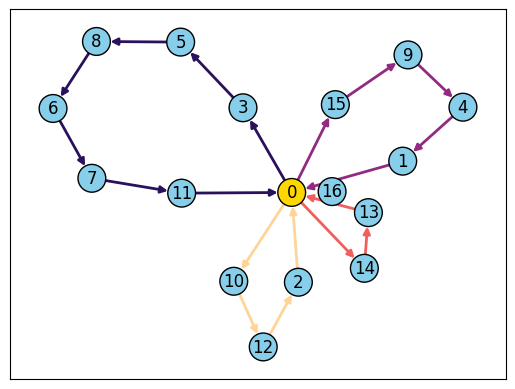

In [ ]:
#For testing
y_ = Initial_Population_FM(y_shape[0]*y_shape[1]*y_shape[2])
y_flat_ = np.array(y_)
Visualise(y_flat_)
print("Contraint I: ", Constraint_I(y_flat_))
print("Contraint II: ", Constraint_II(y_flat_))
print("Contraint III: ", Constraint_III(y_flat_))
print("Contraint IV: ", Constraint_IV(y_flat_))
print("Contraint V: ", Constraint_V(y_flat_))
#0: blue
#1: purple
#2: orange
#3: yellow

After we can construct a whole initial population using the previous function, and fixing a score upper limit to filter in the best initial solutions we can start with:

In [ ]:
def Construct_Init_Pop_FM(pop_size, n_vars, score_lim = 8000):
    init_pop = []
    best_score = score_lim
    print(f'Finding an initial population of size {pop_size}...')
    while len(init_pop) != pop_size:
        indv = np.array(Initial_Population_FM(n_vars))
        score_indv = hybrid_cost_fct(indv)
        if score_indv < score_lim:
            init_pop.append(tuple(indv))
            print(f'Individual {len(init_pop)} found: score = {score_indv}')
            print(indv.tolist())
    return init_pop

In [ ]:
def Verify_Constraints(indv):
    if Penalise(indv) == 0:
        return 1
    else:
        return 0

The above function helps in identifying the best individual in a current population, by deactivating the cost function when constraints are not met (not used in NSGA-II, only for identifying a best individual after each iteration, but can be used for a regular Genetic Algorithm). Using it, we can define a new cost function:

In [ ]:
def hybrid_cost_fct(x):
    return Verify_Constraints(np.array(x))*cost_fct(np.array(x))+Penalise(np.array(x))

Finally, the modified **NSGA-II** algorithm:

In [ ]:
def NSGA_II_Constraints():
    #Vars
    n_vars = y_shape[0]*y_shape[1]*y_shape[2]
    min_vals = [0]*n_vars
    max_vals = [1]*n_vars
    pop_size = 25
    crossover_rate = 0.9
    mutation_rate = 0.1
    generations = 50
    #Algorithm
    #Initial population: pseudo-random
    #A- no filter on scores
    '''
    init_pop = []
    for _ in range(pop_size):
        indv = Initial_Population_FM(n_vars)
        init_pop.append(tuple(indv))
    '''
    #B- Filtered scores
    init_pop = Construct_Init_Pop_FM(pop_size, n_vars, score_lim = 8000)
    print('Initial values: ',init_pop)
    current_pop = init_pop[:]
    for _ in range(generations):
        parents = Tournament_Selection_FM(current_pop, k=5)
        children = Crossover(parents, crossover_rate)
        children = Mutation_FM(children, mutation_rate, min_val=0, max_val=1)
        #current_pop = children[:]

        combined_pop = current_pop + children
        combined_fits = [(Penalise(np.array(x)), cost_fct(np.array(x)))  for x in combined_pop]
        fronts = non_dominated_sort_FM(combined_pop, combined_fits)
        #print(fronts)
        new_pop_idcs = []
        #Get the best pop_size individuals from the pareto front
        for front in fronts:
            if (len(new_pop_idcs)+len(front)) <= pop_size:
                new_pop_idcs.extend(front)
            else:
                #fcts_ = [cost_fct, Constraint_I, Constraint_II, Constraint_III, Constraint_IV]
                fcts_ = [Penalise, cost_fct]
                dists = crowded_distance(combined_pop, front, fcts=[lambda x: fct(np.array(x)) for fct in fcts_])
                sorted_front = sorted(range(len(front)), key=lambda x: dists[x], reverse=True)
                new_pop_idcs.extend(sorted_front[:pop_size-len(new_pop_idcs)])
        current_pop = [combined_pop[idx] for idx in new_pop_idcs]


        print('Generation number: ',_)
        #To monitor the evolution of the population
        print(f'scores = {[hybrid_cost_fct(np.array(x)) for x in combined_pop]}')
        #Find the best individual
        print('Best individual in the population:')
        best_indv = min(current_pop, key=lambda x: hybrid_cost_fct(x))
        print('Repeated? ',current_pop.count(best_indv))
        #print('Is in current population? ',best_indv in current_pop)
        '''
        best_idx = 0
        for idx, indv in enumerate(current_pop):
            if Is_Dominant_FM(np.array(indv),np.array(current_pop[best_idx])):
                best_idx = idx
        best_indv = np.array(current_pop[best_idx])
        '''
        best_indv = np.array(best_indv)
        print("Cost function: ", cost_fct(best_indv))
        print("Constraint I: ", Constraint_I(best_indv))
        print("Constraint II: ", Constraint_II(best_indv))
        print("Constraint III: ", Constraint_III(best_indv))
        print("Constraint IV: ", Constraint_IV(best_indv))
        print("Constraint V: ", Constraint_V(best_indv))

    return best_indv

Finding an initial population of size 25...
Individual 1 found: score = 7723.2
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

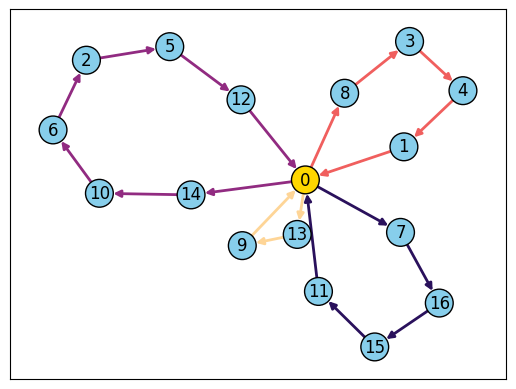

In [ ]:
best_sol = NSGA_II_Constraints()

print(best_sol.tolist())
Visualise(best_sol)

print("Cost function: ", cost_fct(best_sol))
print("Constraint I: ", Constraint_I(best_sol))
print("Constraint II: ", Constraint_II(best_sol))
print("Constraint III: ", Constraint_III(best_sol))
print("Constraint IV: ", Constraint_IV(best_sol))
print("Constraint V: ", Constraint_V(best_sol))


#print('\nNSGA-II algorithm for the flower market:')
#print('Optimal solutions found with NSGA-II: \n', np.array(current_pop))
#print('Cost fct values for optimal sols: ', [round(cost_fct(np.array(x)),3) for x in current_pop])

We execute the algorithm several times, with different parameters each time, in search for an optimal solution. We raise, in some of these tries, the mutation rate as a higher mutation rate helps us explore the search space, potentially leading to better solutions.<br>
That being said, we are very limited by the available computational power, which is not enough for such a heavy algorithm.

In addition, having a low population count means having less diversity, and the algorithm therefore finds less quality solutions. But Raising it significantly raises the execution time.

We have collected a number of solutions in the **solutions.py** file. Here is the best solutions we've found so far:

Cost function:  5756.799999999999
Contraint I:  0
Contraint II:  0
Contraint III:  0
Contraint IV:  0
Contraint V:  0


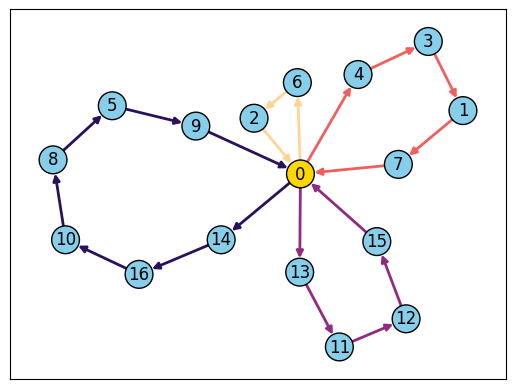

In [ ]:
y_best = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
#Cost function: 5756.799
y_flat_best = np.array(y_best)
Visualise(y_flat_best)
print("Cost function: ", cost_fct(y_flat_best))
print("Contraint I: ", Constraint_I(y_flat_best))
print("Contraint II: ", Constraint_II(y_flat_best))
print("Contraint III: ", Constraint_III(y_flat_best))
print("Contraint IV: ", Constraint_IV(y_flat_best))
print("Contraint V: ", Constraint_V(y_flat_best))
#0: blue
#1: purple
#2: orange
#3: yellow